In [1]:
import pandas as pd
import numpy as np
import os
import string
import datetime
from datetime import timezone
os.getcwd()
import glob
import pytz
import seaborn as sns
import re

In [2]:
def convert_mm(value):
    #length in mm transformed to float
    try:
        new_value = value.replace(' mm','')
        return float(new_value)    
    except AttributeError:
        return np.NaN

In [3]:
def convert_exposure(value):
    #length in mm transformed to float
    try:
        list_string=value.split('/')
        if (len(list_string)==1):
            return float(value)
        else:
            return float(list_string[0])/float(list_string[1])
    except AttributeError:
        #print ('WTF',value)
        return np.NaN
    #return float(0)
        

In [4]:
def remove_full_path(value):
    #all pictures originate from a Pictures folder, remove the full path
    #including Pictures
    try:
        list_string=value.split('/Pictures')
        return list_string[1]
    except AttributeError:
        return np.NaN

In [5]:
def extractCityV2(filename):
    m = re.search(r'(?<=\s-\s)\D+?(,)', filename)
    if m==None:
        print("error in",filename)
    else:
        #print("test",m[0][:-1])
        return m[0][:-1]

In [6]:
def funcDayPeriod(filename):
    search_night=["bei Nacht",'Sternenhimmel',"Mondschein","Mond","Ice and Snow/"]
    search_night_special=["Lumiere","euerwerk","Firework","Freudenfeuer"]
    search_twilight=["bei anbrechender Nacht","Abenddaemmerung","Morgendaemmerung","Sonnenaufgang"]
    if any (x in filename for x in search_night):
        return -1
    elif any(x in filename for x in search_night_special):
         return 0
    elif any(x in filename for x in search_twilight):
        return 3
    elif "bei Sonnenuntergang" in filename:
        return 2
    else:
        return 1

In [7]:
def funcComposite(filename):
    if "Panorama." in filename:
        return 1
    else:
        return 0

In [8]:
def funcMovie(filename):
    search_file_names=[".JPG",".jpg",".JPEG",".jpeg"]
    if any(x in filename for x in search_file_names):
        return 0
    else:
        return 1

In [9]:
def funcTimeZoneCorrectionNYCBias(value,filename,modelname,data_min,data_max):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            #date is ordered by 
            #date_orig = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            date = value
            if modelname=="SP500UZ":
                if(date>data_min and date<data_max):
                #never changed timezone after getting back from NYC, all messed up
                    date=date+datetime.timedelta(hours=6)
            return date
    except AttributeError:
        return np.NaN

In [10]:
def funcTimeZoneCorrection(value,filename,modelname):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            date = value
            search_names_NYC_time_zone=["- Philadelphia,","New York City,","Newark,","Washington Airport"]
            search_names_London_time_zone_CANON600D=["Dublin & Nordirland/P","120830-120909 - Portugal/","Suedengland/","141212-141214 - London/","Greater London"]
            search_names_Istanbul_time_zone_CANON600D=["41023-141027 - Istanbul/","150828-150912 Sankt Petersburg/"]
            search_names_pacific_time_zone_CANON600D=["150613 - Los Angeles/","USA/P818"," - Grand Canyon Village, "," - Boulder City, "," - Las Vegas, "]
            search_names_China_time_zone_CANON80D=["180101 China/","/171230 Shanghai"," - China, "]
            search_names_EastEurope_time_zone_CANON80D=["170603 Athen/","171006 Tallinn ","/170414 Kiev"," - Tuerkei, "," - Irak, "," - Kuwait"," - Qatar, "]
            search_names_London_time_zone_CANON80D=[" - Saudi-Arabien,","/190413-190417 Suedostengland/"," - United Kingdom - ","/171110 Marrakesch/","170915 London/P","/180602 UK/"]
            search_names_Iceland_time_zone_CANON80D=[" - Island, ","/180328 Island/"]
            search_names_Gulf_time_zone_CANON80D=[" - Island, "," - Dubai, "]
            search_names_Pakistan_time_zone_CANON80D=[" - Pakistan, "]
            search_names_Korea_time_zone_CANON80D=[" - Paju, "," - Suwon, "," - Seoul, "," - Busan,"," - Incheon, "," - Gyeongju, "," - Gwanju, "]
            if modelname=="SP500UZ":
                hour_bias=0
                data_max_olympus=datetime.datetime.now()
                date_max_olympus=datetime.date(2008,9,1)
                if(date.date()<date_max_olympus):
                    hour_bias=24
                #no change of default time, thus London time is an hour too late
                if "London/P" in filename:  
                    date=date-datetime.timedelta(hours=1)+datetime.timedelta(hours=hour_bias)
                    return date
                elif any(x in filename for x in search_names_NYC_time_zone):
                    date=date-datetime.timedelta(hours=6)+datetime.timedelta(hours=hour_bias)
                    return date
                elif " Chicago - Edit2012/P" in filename:
                    date=date-datetime.timedelta(hours=7)+datetime.timedelta(hours=hour_bias)
                    return date    
                else:
                    value_new=date+datetime.timedelta(hours=hour_bias)
                    return value_new
            if modelname=="Canon EOS 600D":
                #all of EOS600D done including 2015
                if any(x in filename for x in search_names_London_time_zone_CANON600D):
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif any(x in filename for x in search_names_Istanbul_time_zone_CANON600D):
                    date=date+datetime.timedelta(hours=1) 
                    return date
                elif any(x in filename for x in search_names_pacific_time_zone_CANON600D):
                    date=date-datetime.timedelta(hours=9)
                    return date
                elif "- Chicago, " in filename:
                    date=date-datetime.timedelta(hours=7)
                    return date
                elif " - Washington D.C., " in filename:
                    date=date-datetime.timedelta(hours=6)
                    return date
                elif "/160813 - USA/" in filename:
                    #remaining 2016 US trip times
                    date=date-datetime.timedelta(hours=8)
                    return date
                elif "161205 - Japan/" in filename:
                    date=date+datetime.timedelta(hours=7)
                    return date
                else:
                    #change to default summer time
                    return date
            if modelname=="Canon PowerShot S110":  
                 #all running on summer time
                if any(x in filename for x in search_names_London_time_zone_CANON600D): 
                    date=date-datetime.timedelta(hours=2)
                    return date
                elif "41023-141027 - Istanbul/" in filename:
                    #for Istanbul timezone was not aligned with CANON EOS600D
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif "150613 - Los Angeles/" in filename:
                    date=date-datetime.timedelta(hours=10)
                    return date
                elif "/2016/" in filename:
                    if "161205 - Japan/" in filename:
                        date=date+datetime.timedelta(hours=6)
                        return date
                    else:
                        #change to default summer time
                        date=date-datetime.timedelta(hours=1)
                        return date
                else:
                    #change to default summer time
                    date=date-datetime.timedelta(hours=1)
                    return date
            if modelname=="Canon EOS 80D":
                if any(x in filename for x in search_names_China_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=6)
                    return date
                elif any(x in filename for x in search_names_EastEurope_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=1)
                    return date
                elif any(x in filename for x in search_names_London_time_zone_CANON80D):
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif " - Groenland" in filename:
                    date=date-datetime.timedelta(hours=4)
                    return date
                elif any (x in filename for x in search_names_Iceland_time_zone_CANON80D):
                    date=date-datetime.timedelta(hours=2)
                    return date
                elif "/170609 USA/" in filename:
                    date=date-datetime.timedelta(hours=8)
                    return date
                elif any(x in filename for x in search_names_Gulf_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=2)
                    return date
                elif any(x in filename for x in search_names_Pakistan_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=3)
                    return date
                elif any(x in filename for x in search_names_Korea_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=7)
                    return date
                else:
                    #always on summer time
                    return date
    except AttributeError:
        return np.NaN

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


dataframe_list=[]

datamax=datetime.datetime.now()
datamin=datetime.datetime.now()


"""    
columns_to_keep=['SourceFile','Aperture','AspectRatio','AutoISO','BaseISO','BitsPerSample',
                'ColorSpace','ColorTemperature','Contrast','DateTimeOriginal','DateTimeOriginal'
                    'ExposureTime','FileName','Flash','FocalLength','FocalLength35efl','ImageSize',
                    'ImageWidth','ISO','Lens','Lens35efl','LightValue','MaxAperture','MinAperture','MinFocalLength',
                     'Model','Orientation','PictureStyle','Quality','RedBalance','ShutterSpeed',
                    'TargetAperture','TimeZone','TimeZoneCity','WB_RGGBLevels','WB_RGGBLevelsAsShot',
                    'WBBracketMode','WhiteBalance','WhiteBalanceBlue','WhiteBalanceRed']
"""

for input in range(2006,2021):
    #print("get to year",input)
    file_name=("outputEXIFcsvsFullInfo/PhotoEXIFDataFull_%s.csv"%(str(input)))
#    df=pd.read_csv(file_name)
#    df=df.dropna(subset=['BitsPerSample'])
    df_test=pd.read_csv(file_name, encoding= 'unicode_escape')
    df_test=df_test.dropna(subset=['BitsPerSample'])
#for c in df_test.columns:
#    print("col",c,df_test[c].isna().sum(),df_test.shape)

    columns_to_keep=['SourceFile','Aperture','BitsPerSample','ColorSpace','Contrast',
                 'DateTimeOriginal','ExposureTime','FileName','Flash','FocalLength','CreateDate',
                 'FocalLength35efl','ImageSize','ImageWidth','ISO','LightValue','Model','Orientation',
                 'Quality','ShutterSpeed','WhiteBalance']
    df_test=df_test[columns_to_keep]
    df_test["Place"]=df_test.apply(lambda x: extractCityV2(x['SourceFile']), axis=1)
    df_test['SourceFile']=df_test['SourceFile'].apply(remove_full_path)    
    df_test['FocalLength']=df_test['FocalLength'].apply(convert_mm) 
    df_test['ExposureTime']=df_test['ExposureTime'].apply(convert_exposure)
    df_test=df_test.replace({'DateTimeOriginal': {'0000:00:00 00:00:00': '2006:01:10 15:20:30'}})
    df_test['DateTimeOriginal']=pd.to_datetime(df_test['DateTimeOriginal'],format='%Y:%m:%d %H:%M:%S')
    df_test['year']=int(input)
    df_test['dayperiod']=df_test.apply(lambda x: funcDayPeriod(x['SourceFile']), axis=1)
    df_test['CompositePhoto']=df_test.apply(lambda x: funcComposite(x['SourceFile']), axis=1)
    df_test['Movie']=df_test.apply(lambda x: funcMovie(x['SourceFile']), axis=1)
    df_test.rename(columns={'DateTimeOriginal':'Date','FocalLength':'FocalLength in mm'},inplace=True) 
    df_test['Date']=df_test.apply(lambda x: funcTimeZoneCorrection(x['Date'],x['SourceFile'],x['Model']), axis=1)
    #total_rows=df_test['SourceFile'].count()
    if(input==2009 or input ==2010):
        if input==2009:
            test=df_test.loc[df_test['SourceFile'].str.contains("P7080022 - New York City")]
            datamin=df_test.at[test.index.values.astype(int)[0],"Date"]   
            print("correction should begin somewhere here 2009",test,"index is",test.index.values.astype(int)[0],datamin)
            df_test['Date']=df_test.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
        elif input==2010:    
            test=df_test.loc[df_test['SourceFile'].str.contains("P8270068 - Le Locle, unterirdische Muehlen")]
            print("correction should end somewhere here 2010",test,"index is",test.index.values.astype(int)[0],datamax)
            datamax=df_test.at[test.index.values.astype(int)[0],"Date"] 

            df_test['Date']=df_test.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
    dataframe_list.append(df_test)
#df = pd.DataFrame(dataframe_list, columns=columns_to_keep)
#print(dataframe_list[0])

combine_all_data=pd.DataFrame(dataframe_list[0]) 
dataframe_list.pop(0)
for data in dataframe_list:
        #print(data.head)
    combine_all_data=pd.concat([combine_all_data,data],ignore_index=True,sort=False)


combine_all_data.to_csv("pictureData/PhotoEXIFDataStripped_2006_2020.csv")
combine_all_data


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,4,6,7,8,9,12,13,14,15,21,22,24,34,40,42,44,45,46,48,49,51,71,79,81,82,83,84,86,87,94,104,110,111,112,115,122,130,136,140,142,143,145,149,150,151,152,158,160,162,163,164,165,166,167,169,177,195,204,205,206,209,212,213,216,218,219,220,223,226,239,240,241,242,245,246,247,250,256,257,262,265,288,290,295,300,301,308,310,319,321,322,325,326,327,328,332,335,336,337,338,339,340,345,347,349,353,354,355,357,364,365,366,367,368,369,370,371,372,373,374,375,376,394,395) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,3,6,7,10,11,14,15,19,21,23,24,29,30,34,36,38,39,40,42,43,45,46,48,49,51,53,54,58,59,60,61,63,66,67,70,71,72,73,76,77,78,79,80,81,82,85,86,87,88,89,90,91,107,114,116,125,127,129,130,131,

correction should begin somewhere here 2009                                              SourceFile  Aperture  \
3277  /2009/090623 USA CTEQ09/090703 New York City/P...       3.0   

      BitsPerSample ColorSpace Contrast                Date  ExposureTime  \
3277            8.0       sRGB   Normal 2009-07-08 13:48:04        0.0125   

                                               FileName              Flash  \
3277  P7080022 - New York City, Lufthansa Boeing 747...  Off, Did not fire   

      FocalLength in mm  ...    Model          Orientation      Quality  \
3277                7.8  ...  SP500UZ  Horizontal (normal)  HQ (Normal)   

      ShutterSpeed  WhiteBalance          Place  year dayperiod  \
3277          1/80          Auto  New York City  2009         1   

     CompositePhoto Movie  
3277              0     0  

[1 rows x 26 columns] index is 3277 2009-07-08 13:48:04


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,3,4,5,6,7,8,11,13,21,23,25,26,39,40,41,43,45,46,47,49,50,52,54,55,73,74,76,78,79,80,90,93,97,99,109,115,117,118,119,120,137,145,147,149,150,152,155,156,160,162,164,166,167,168,169,170,171,172,173,180,185,186,187,188,190,196,213,214,216,218,224,225,226,228,229,232,247,250,253,261,262,264,272,278,279,280,286,291,308,310,313,315,316,317,318,321,322,323,345,346,372,373,374,376,385,389,399,400,401,402,403,407,410,416,417,418,419,423,424,426,428) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


correction should end somewhere here 2010                                              SourceFile  Aperture  \
5389  /2010/100827 Jura/P8270068 - Le Locle, unterir...       2.8   

      BitsPerSample ColorSpace Contrast                Date  ExposureTime  \
5389            8.0       sRGB   Normal 2010-08-27 16:15:55           2.5   

                                            FileName              Flash  \
5389  P8270068 - Le Locle, unterirdische Muehlen.JPG  Off, Did not fire   

      FocalLength in mm  ...    Model   Orientation Quality  ShutterSpeed  \
5389                6.3  ...  SP500UZ  Rotate 90 CW     NaN           2.5   

      WhiteBalance     Place  year dayperiod CompositePhoto Movie  
5389          Auto  Le Locle  2010         1              0     0  

[1 rows x 26 columns] index is 5389 2020-11-30 18:40:02.783043


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,5,6,7,9,15,16,17,19,29,32,37,38,39,41,42,44,45,54,56,61,63,64,68,74,75,76,78,80,82,83,84,92,98,100,101,102,111,114,122,136,138,139,140,142,149,151,153,156,157,158,159,160,165,167,170,171,172,173,174,180,184,189,192,195,202,208,209,212,213,214,215,219,221,222,223,226,227,228,231,239,242,256,257,260,261,264,266,273,278,279,280,281,283,284,285,287,288,290,293,307,312,323,325,332,333,344,345,348,350,355,359,360,361,362,367,370,374,375,381,387,389,390,391,400) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,5,12,15,16,28,32,34,49,50,51,52,64,65,73,109,118,134,135,137,138,140,145,161,179,180,191,200,212,214,215,219,220,225,232,240,241,245,250,253,255,256,259,260,261,263,273,276,282,290,293,

error in /Volumes/Backup Plus/Pictures/2017/170609-170623 USA/P6090043 - Wolkenmeer ueber Atlantik.JPG
error in /Volumes/Backup Plus/Pictures/2017/170609-170623 USA/P6090044 - Atlantik mit Schelfeis.JPG


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,6,7,13,14,22,24,31,33,34,35,36,42,47,48,49,50,53,56,57,59,62,63,65,66,71,79,80,84,87,89,101,102,103,106,110,111,112,113,117,118,119,121,134,135,139,140,142,145,146,147,148,150,155,157,169,170,174,175,176,177,178,180,186,187,188,191,192,193,206,212,218,220,221,230,231,241,244,248,249,256,257,259,264,265,268,270,272,275,277,278,279,280,281,282,283,284,287,292,293,297,302,303,304,305,306,308,310,312,313,314,315,316,317,318,320,321,324,325,326,327,330,331,334,335,338,340,344,345,347,348,351,352,353,356,357,360,363,364,365,366,370,380,383,385,388,393,395,398,399,400,410,411,412,414,415,417,421,429,436,437,440,442,444,447,448,451,452,453,458,460,465,476,478,479,480,481,487,488,489,491,492,494,497,498,499,501,502,503,504,505,506,507,508,509,510,513,515,517,522,523,524,525,527,529,530,531,532,533,539,542,543,545,547,549,552,554,556,564,565,567,568,572,573,585,590,591,596,601,603,605,606,6

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,Model,Orientation,Quality,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:11:39,0.008000,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",18.5,...,SP500UZ,NaN,SQ (Low),1/125,Auto,Frankreich,2006,1,0,0
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:12:06,0.004000,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",33.0,...,SP500UZ,NaN,SQ (Low),1/250,Auto,Frankreich,2006,1,0,0
2,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006-11-25 13:47:12,0.001250,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",14.9,...,SP500UZ,Horizontal (normal),HQ (Normal),1/800,Auto,Chamonix,2006,1,0,0
3,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006-11-25 13:47:23,0.005000,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",14.9,...,SP500UZ,Horizontal (normal),HQ (Normal),1/200,Auto,Chamonix,2006,1,0,0
4,"/2006/061124 Chamonix/PB240007 - Chamonix, Gar...",4,8.0,sRGB,Normal,2006-11-25 14:10:18,0.002000,"PB240007 - Chamonix, Gare mit Aig. & Dome du G...","Off, Did not fire",9.9,...,SP500UZ,NaN,SQ (Low),1/500,Auto,Chamonix,2006,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102268,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",4,8.0,sRGB,Normal,2020-11-22 15:28:30,0.020000,"PB220028 - Todtmoos, Ruettebach.JPG","Off, Did not fire",18.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/50,Daylight,Todtmoos,2020,1,0,0
102269,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",5,8.0,sRGB,Normal,2020-11-22 16:27:51,0.016667,"PB220062 - St Blasien, Kloster.JPG","Off, Did not fire",18.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/60,Auto,Todtmoos,2020,1,0,0
102270,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",3.5,8.0,sRGB,Normal,2020-11-22 16:17:30,0.040000,"PB220045 - St Blasien, Kloster - Dom, Chor.JPG","Off, Did not fire",18.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/25,Daylight,Todtmoos,2020,1,0,0
102271,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",7.1,8.0,sRGB,Normal,2020-11-22 15:07:44,0.008000,"PB220003 - Todtmoos, Ruettebach mit Wiesen und...","Off, Did not fire",22.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/125,Auto,Todtmoos,2020,1,0,0


In [12]:
combine_all_data[combine_all_data["year"]==2020]["Place"].nunique()

97

In [13]:
combine_all_data["Place"].unique()

array(['Frankreich', 'Chamonix', 'Montenvers', 'Les-Houches', 'Basel',
       'London', 'Windsor', 'Meryin', 'Meyrin', 'Genf', 'Kuessaberg',
       'Lauchringen', 'Goerwihl', 'Tiengen', 'Zuerich', 'Schweiz',
       'Zermatt', 'Sion', 'St Niklaus', 'Randa', 'Singen', 'Birnau',
       'Meersburg', 'Cessy', 'Carouge', 'Lausanne', 'Zurzach',
       'Einsiedeln', 'Schwyz', 'Montreux', 'Aarau', 'Veytaux',
       'Villeneuve', 'Naefels', 'St Gallen', 'Dresden', 'Meissen',
       'Moritzburg', 'Annecy', 'Frankfurt', 'Philadelphia', 'Madrid',
       'El Escorial', 'Segovia', 'Segoiva', 'Lauterbrunnen',
       'Grindelwald', 'Fieschertal', 'Nuernberg', 'St Blasien', 'Sarnen',
       'Neuchatel', 'Solothurn', 'Bern', 'Konstanz', 'Reichenau',
       'Neuhausen', 'Rheinau', 'Morges', 'Nyon', 'Paris', 'Hebron',
       'Madison', 'Chicago', 'New York City', 'Jersey City', 'Getafe',
       'Toledo', 'St Maurice', 'St Leonhard', 'Brig', 'Blick',
       'Karlsruhe', 'Mainz', 'Speyer', 'Fankfurt', 'Mannh

In [14]:
combine_all_data["Place"]=combine_all_data["Place"].fillna(value='Atlantic')

In [15]:
combine_all_data[combine_all_data["Place"].str.contains("Q")]["Place"].unique()

array(['Queluz', 'Queensferry', 'North Queensferry', 'Qatar',
       'Quedlinburg', 'Quinten'], dtype=object)

In [16]:
combine_all_data[combine_all_data["Place"].str.contains("Sankt Petersburg")]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,Model,Orientation,Quality,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie


In [17]:
test_place=combine_all_data.groupby(["Place"]).agg(PhotosPerCity=('SourceFile','count')).sort_values(by="PhotosPerCity",ascending=False).reset_index()
# post process Chateau d'Oex,\ 
test_place.head(35)

,Place,PhotosPerCity
0,Rom,5417
1,Genf,4574
2,Paris,3724
3,London,2284
4,Florenz,1815
5,Zermatt,1523
6,Chamonix,1366
7,Muenchen,1357
8,Venedig,1347
9,Wien,1309


In [30]:
test_place[test_place["PhotosPerCity"]>299]

,Place,PhotosPerCity
0,Rom,5417
1,Genf,4574
2,Paris,3724
3,London,2284
4,Florenz,1815
5,Zermatt,1523
6,Chamonix,1366
7,Muenchen,1357
8,Venedig,1347
9,Wien,1309


In [18]:
combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data.dtypes

SourceFile                        object
Aperture                          object
BitsPerSample                    float64
ColorSpace                        object
Contrast                          object
Date                 datetime64[ns, UTC]
ExposureTime                     float64
FileName                          object
Flash                             object
FocalLength in mm                float64
CreateDate                        object
FocalLength35efl                  object
ImageSize                         object
ImageWidth                       float64
ISO                              float64
LightValue                       float64
Model                             object
Orientation                       object
Quality                           object
ShutterSpeed                      object
WhiteBalance                      object
Place                             object
year                               int64
dayperiod                          int64
CompositePhoto  

In [19]:
def funcImputeDate(valueDate,valueCreateDate,source):
    if pd.isnull(valueDate):
        #print("WTF na")
        #print(source)
        if pd.isnull(valueCreateDate):
            return pd.NaT
        else:
            try:         
                return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M:%S')
            except ValueError:
                try:          
                    return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M:%S%z')
                except ValueError:
                    print(valueCreateDate)          
                    return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M%z')
    else:
        return valueDate

In [20]:
combine_all_data[(combine_all_data['CreateDate']=='0000:00:00 00:00:00')][['SourceFile','Date','CreateDate']]

,SourceFile,Date,CreateDate
439,"/2006/Lauchringen/P1010001 - Kuessaberg, KuÌs...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
440,"/2006/Lauchringen/P1010002 - Kuessaberg, Papa,...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
441,"/2006/Lauchringen/P1010003 - Kuessaberg, Hanns...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
442,"/2006/Lauchringen/P1010004 - Kuessaberg, Artur...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
443,"/2006/Lauchringen/P1010005 - Kuessaberg, Kuess...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
444,"/2006/Lauchringen/P1010006 - Kuessaberg, Kuess...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
445,"/2006/Lauchringen/P1010007 - Kuessaberg, Kuess...",2006-01-11 15:20:30+00:00,0000:00:00 00:00:00
446,"/2006/Lauchringen/P1010008 - Kuessaberg, Kuess...",2006-01-11 15:20:30+00:00,0000:00:00 00:00:00
447,"/2006/Lauchringen/P1010012 - Lauchringen, Heid...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
448,"/2006/Lauchringen/P1010016 - Lauchringen, Anne...",2006-01-11 15:20:30+00:00,0000:00:00 00:00:00


In [21]:
combine_all_data[combine_all_data['Date'].isna()][['SourceFile','Date','CreateDate']]
#pd.to_datetime(df_test[df_test['CreateDate'].notna()]['CreateDate'])
combine_all_data['Date']=combine_all_data.apply(lambda y: funcImputeDate(y['Date'],y['CreateDate'],y['SourceFile']), axis=1)
combine_all_data.to_csv("pictureData/PhotoEXIFDataStripped_2006_2020_CorrectDates.csv")
combine_all_data

2013:09:15 21:45+02:00
2014:08:06 16:59+02:00


,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,Model,Orientation,Quality,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:11:39+00:00,0.008000,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",18.5,...,SP500UZ,NaN,SQ (Low),1/125,Auto,Frankreich,2006,1,0,0
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:12:06+00:00,0.004000,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",33.0,...,SP500UZ,NaN,SQ (Low),1/250,Auto,Frankreich,2006,1,0,0
2,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006-11-25 13:47:12+00:00,0.001250,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",14.9,...,SP500UZ,Horizontal (normal),HQ (Normal),1/800,Auto,Chamonix,2006,1,0,0
3,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006-11-25 13:47:23+00:00,0.005000,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",14.9,...,SP500UZ,Horizontal (normal),HQ (Normal),1/200,Auto,Chamonix,2006,1,0,0
4,"/2006/061124 Chamonix/PB240007 - Chamonix, Gar...",4,8.0,sRGB,Normal,2006-11-25 14:10:18+00:00,0.002000,"PB240007 - Chamonix, Gare mit Aig. & Dome du G...","Off, Did not fire",9.9,...,SP500UZ,NaN,SQ (Low),1/500,Auto,Chamonix,2006,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102268,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",4,8.0,sRGB,Normal,2020-11-22 15:28:30+00:00,0.020000,"PB220028 - Todtmoos, Ruettebach.JPG","Off, Did not fire",18.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/50,Daylight,Todtmoos,2020,1,0,0
102269,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",5,8.0,sRGB,Normal,2020-11-22 16:27:51+00:00,0.016667,"PB220062 - St Blasien, Kloster.JPG","Off, Did not fire",18.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/60,Auto,Todtmoos,2020,1,0,0
102270,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",3.5,8.0,sRGB,Normal,2020-11-22 16:17:30+00:00,0.040000,"PB220045 - St Blasien, Kloster - Dom, Chor.JPG","Off, Did not fire",18.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/25,Daylight,Todtmoos,2020,1,0,0
102271,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",7.1,8.0,sRGB,Normal,2020-11-22 15:07:44+00:00,0.008000,"PB220003 - Todtmoos, Ruettebach mit Wiesen und...","Off, Did not fire",22.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/125,Auto,Todtmoos,2020,1,0,0


In [22]:
combine_all_data[combine_all_data['Date'].isna()][['SourceFile','Date','CreateDate']]

,SourceFile,Date,CreateDate
5530,/2009/090623 USA CTEQ09/090703 New York City/P...,NaT,NaN
18475,/2011/Lauchringen/P4240022-P420024 - Lauchring...,NaT,NaN
18514,"/2011/Private/PC310001 - Rust, Matthias im Eur...",NaT,NaN
53786,/2016/160910 Verbier & Hermence/P9110084 - Her...,NaT,NaN
53787,/2016/160910 Verbier & Hermence/P9110085 - Her...,NaT,NaN
53788,/2016/160910 Verbier & Hermence/P9110086 - Her...,NaT,NaN
53789,/2016/160910 Verbier & Hermence/P9110087 - Her...,NaT,NaN
53790,/2016/160910 Verbier & Hermence/P9110088 - Her...,NaT,NaN
53791,/2016/160910 Verbier & Hermence/P9110089 - Her...,NaT,NaN
53792,/2016/160910 Verbier & Hermence/P9110090 - Her...,NaT,NaN


<AxesSubplot:title={'center':'monthly count of  pictures'}, xlabel='Date', ylabel='picture count'>

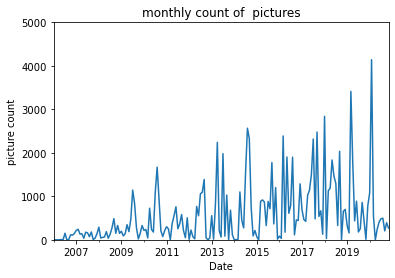

In [23]:
combine_all_data['Date']=pd.to_datetime(combine_all_data['Date'], utc=True)
#combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data.groupby(pd.Grouper(key="Date", freq="M")).count()["SourceFile"].plot(title="monthly count of  pictures",ylabel="picture count",ylim=(0,5000))

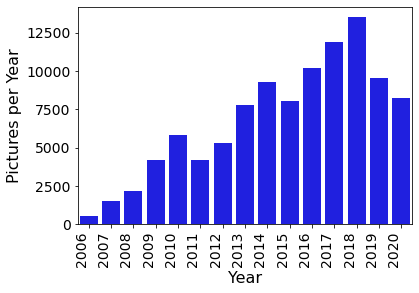

In [24]:
df_group=combine_all_data.groupby(pd.Grouper(key="Date", freq="Y")).count()["SourceFile"].reset_index()

ax = sns.barplot(x="Date", y="SourceFile", data=df_group,color = 'blue') 
x_dates = df_group['Date'].dt.strftime('%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right')
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('Pictures per Year',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

In [25]:
combine_all_data.groupby([combine_all_data["Date"].dt.hour]).count()

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,Model,Orientation,Quality,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie
Date,,,,,,,,,,,,,,,,,,,,,
0.0,351,343,351,351,337,351,343,351,343,343,...,351,341,331,343,343,351,351,351,351,351
1.0,509,500,509,509,480,509,500,509,500,500,...,509,502,478,500,500,509,509,509,509,509
2.0,595,588,595,595,580,595,588,595,588,588,...,595,588,574,588,588,595,595,595,595,595
3.0,598,589,598,598,587,598,589,598,589,589,...,598,590,566,589,589,598,598,598,598,598
4.0,430,425,430,430,425,430,425,430,425,425,...,429,426,414,425,425,430,430,430,430,430
5.0,458,452,458,458,449,458,452,458,452,452,...,458,453,412,452,452,458,458,458,458,458
6.0,998,985,998,998,933,998,985,998,985,985,...,998,987,886,985,985,998,998,998,998,998
7.0,2030,1981,2030,2030,1701,2030,1981,2030,1981,1981,...,2030,1993,1660,1981,1981,2030,2030,2030,2030,2030
8.0,4630,4550,4630,4630,3898,4630,4550,4630,4550,4550,...,4629,4563,3854,4550,4550,4630,4630,4630,4630,4630
